# 3D SETUP FOR PRACTICAL AND IDEAL MODELS

In [116]:
import matplotlib.pyplot as plt
import numpy as np 
import cmath
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d

from Functions import *

User positions:
 [[ -958.37618852 -1494.74781405]
 [ -494.37069482 -1650.99540913]
 [ -558.09281716  -975.06217492]
 [ -873.09532963  -910.31006037]
 [ -121.12201964   971.63129007]
 [  456.90664146 -1945.04729603]
 [   68.06018207  -474.34937227]
 [  828.71388186   810.35811066]
 [-1471.77267042   -85.19732882]
 [  807.79132127 -1009.24809026]
 [-1933.90302069  -367.93698978]
 [ -755.54129938   288.46853912]]

Transmit antenna(e) coordinates:
 [[0. 0.]]

IRS elements coordinates:
 [[499.9625 499.9625]
 [500.0375 499.9625]
 [499.9625 500.0375]
 [500.0375 500.0375]]

Distances b/w the antennas and the users:
 [[ 958.37618852  494.37069482  558.09281716  873.09532963  121.12201964
   456.90664146   68.06018207  828.71388186 1471.77267042  807.79132127
  1933.90302069  755.54129938]]
(1, 12)

Distances b/w the IRS/IRS elements and the users:
 [[1458.37618852  994.37069482 1058.09281716 1373.09532963  621.12201964
    43.09335854  431.93981793  328.71388186 1971.77267042  307.79132127
  24

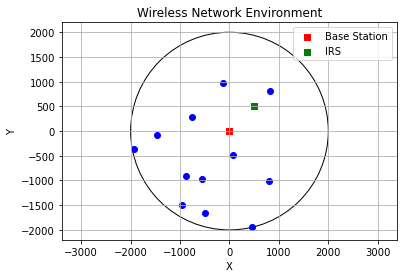

In [160]:
#============== System parameters
Nt = 1
nIRSrow = 2
nIRScol = nIRSrow
Ns = nIRSrow*nIRScol
K = 12
# gamma = db2pow(20)
f = 2e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
# N0 = db2pow(-174-30)
B = 2
# sigma = np.sqrt(B*N0)
# epsilon = 1e-3
# Xi = 0.001
# relChange = 1e3
# iIter = 0
# objSeq = []

GRID_RADIUS = 2000
BASE_STATION_POSITION = (0, 0)
TRANSMIT_POWER_WATTS = 2 #in watts
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
PATH_LOSS_EXPONENT = 3.5 #path loss exponent (direct)
BETA = 2 #path loss exponent (indirect)
BANDWIDTH = 50*(10**6) #in Hz
m = 1
omega = 1.0

IRS_POSITION = (500,500)
NUM_SIMULATIONS = 100

# Generate user positions
user_positions = generate_user_positions_2D(K, GRID_RADIUS)
print('User positions:'"\n", user_positions)
print()
loc_U = user_positions
# print(loc_U)

# Generate antennas position
AP_position = generate_station_positions_2D(BASE_STATION_POSITION)
xt, yt = AP_position[0]

# Generate IRS position
irs_position = generate_IRS_2D(IRS_POSITION)
xs, ys = irs_position[0]

tx_ant_coords = generate_transmit_antenna_coordinates_2D(Nt, xt, yt, halfLambda, quarterLambda)
loc_T = tx_ant_coords
print('Transmit antenna(e) coordinates:'"\n", loc_T) 
print()

irs_coords = generate_irs_coordinates_2D(xs, ys, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S = irs_coords
print('IRS elements coordinates:'"\n", loc_S) 
print()

dTU, dSU, dTS = calculate_distances_2D(loc_U, loc_T, loc_S)

# Reshapiing the distance from antennas/BS to user
dTU = dTU.reshape(Nt,K)
# Compute row-wise averages
dSU = np.mean(dSU, axis=1, keepdims=True)
dSU = dSU.reshape(1,K)
# Compute the sum of elements in each row
dTS = np.mean(dTS, axis=1)
# Compute the average of row sums
dTS = np.mean(dTS)

print('Distances b/w the antennas and the users:'"\n", dTU)
print(np.shape(dTU))
print()
print('Distances b/w the IRS/IRS elements and the users:'"\n", dSU)
print(np.shape(dSU))
print()
print('Distances b/w the antennas and the IRS/IRS elements:'"\n", dTS)
print()

h_dk = []
h_rk = []
h_rk_transpose = []
G = []

# Perform simulations
for i in range(NUM_SIMULATIONS):

    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk1 = []
    fading1 = []
    for user in range(K):
        fading1.append(generate_rayleigh_fading_channel(Nt, FADING_STD_MEAN, FADING_STD_DEV))
    h_dk1 = np.array(fading1)
    h_dk1 = h_dk1.reshape(Nt,K)
    h_dk.append(h_dk1)
    
    # Generate the Nakagami Channel from each user to the IRS (h_rk)
    h_rk1 = []
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m, omega, Ns))
    h_rk1 = np.array(fading)
    h_rk1 = h_rk1.reshape(Ns,K)
    h_rk.append(h_rk1)
    
    h_rk_conj = np.conj(h_rk1)
    h_rk_transpose1 = np.transpose(h_rk_conj)
    h_rk_transpose.append(h_rk_transpose1)
    
    # Generate the Nakagami Channel from base_station to the IRS (G)
    G1 = []
    fading2 = []
    for element in range(Ns):
        fading2.append(generate_nakagami_samples(m, omega, Nt))
    G1 = np.array(fading2)
    G.append(G1)

# Convert 3D arrays to 2D arrays by averaging along axis 0
h_dk = (np.mean(h_dk, axis=0))
h_rk = (np.mean(h_rk, axis=0))
h_rk_transpose = (np.mean(h_rk_transpose, axis=0))
G = (np.mean(G, axis=0))

print("Averaged h_dk: \n", np.shape(h_dk))
print()
print("Averaged h_rk: \n", np.shape(h_rk))
print()
print("Averaged G: \n", np.shape(G))

# Plot the grid, base station, and user positions
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), GRID_RADIUS, edgecolor='black', facecolor='none')
ax.add_patch(circle)
plt.scatter(0, 0, color='red', marker='s', label='Base Station')
plt.scatter(IRS_POSITION[0], IRS_POSITION[1], color='green', marker='s', label='IRS')
plt.scatter(user_positions[:, 0], user_positions[:, 1], color='blue', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Wireless Network Environment')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# # Plot the 3D grid, base station, IRS, and user positions
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xt, yt, color='red', marker='*', label='Base Station')
# ax.scatter(IRS_POSITION[0], IRS_POSITION[1], color='green', marker='s', label='IRS')
# ax.scatter(user_positions[:, 0], user_positions[:, 1], color='blue', marker='o', label='User')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Wireless Network Environment')
# ax.legend()
# ax.grid(True)

# # Draw the circle in the x-y plane
# circle = plt.Circle((xt, yt), (GRID_RADIUS), edgecolor='black', facecolor='none')
# ax.add_patch(circle)
# art3d.pathpatch_2d_to_3d(circle, z=0, zdir='z')  # Add the circle to the x-y plane at z=zt
# plt.show()

# SISO IDEAL PHASE SHIFT MODEL (MULTIPLE USERS)

In [167]:
RATE_THRESHOLD = 26.4

# Initialize an empty list to store theta_n values for each i
theta_n_values_complex = []

for i in range(K):
    theta_n_i = []
    for j in range(Ns):
        # theta_n =  np.angle(h_dk[0][i]) - np.angle(h_rk[j][i]) - np.angle(G[j][0])
        theta_n = np.angle(h_rk[j][i]) - np.angle(G[j][0])
    
        # Adjust theta_n to lie within the range (-π, π)
        theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi
        theta_n_i.append(theta_n)
        
    theta_n_values_complex.append(1 * np.exp(1j * np.array(theta_n_i)))

theta_n_values_complex = np.array(theta_n_values_complex)
# print('Theta_n matrix: ',"\n", np.angle(theta_n_values_complex))
# # print(np.shape(theta_n_values_complex))
# print('h_dk angle: ',"\n", np.angle(h_dk))
# print()

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
for row in theta_n_values_complex:
    diagonal_matrix = np.diag(row[:Ns])
    diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(diagonal_matrices)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))
# print()

# Initialize an empty list to store the results for each column
results_list = []

# Loop over each row/user in the diagonal_matrices
for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user
    single_row_diag = diagonal_matrices[row_index, :, :]
    # print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    single_row = h_rk_transpose[row_index,:]
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row, single_row_diag)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    result = np.dot(result_inter, G)
    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
print('Results array: '"\n", (results_array))
print()
# print('Shape of results array:', results_array.shape) 
# print()
results_array = results_array.reshape(1,K)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * ((((h_dk[0][i])/(np.sqrt((dTU[0][i])**PATH_LOSS_EXPONENT))) + (results_array[0][i])/np.sqrt((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

# # Print link budget values
# print('Link Budget: ') 
# for element in link_budget:
#     print(element)
# print(np.shape(link_budget)) 
# print() 

# # Print SNR values
# print('SNR of all users (in dB): ')
# for element in SNR_matrix:
#     print(element)
# print(np.shape(SNR_matrix)) 
# print() 

# # Print rate values
# print('Rate of all users (in bps/Hz): ')
# for element in rate_matrix:
#     print(element)
# print(np.shape(rate_matrix)) 

rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.3f}".format(outage_probability))

Results array: 
 [[ 29.94244643+3.55271368e-15j]
 [213.02638766-2.84217094e-14j]
 [ 48.06169767+7.10542736e-15j]
 [ 71.05353196+2.84217094e-14j]
 [ 78.06161804-1.42108547e-14j]
 [ 74.24995016+0.00000000e+00j]
 [109.44896248+2.13162821e-14j]
 [ 83.7378929 +0.00000000e+00j]
 [ 51.07600288-1.42108547e-14j]
 [ 70.39765963+3.19744231e-14j]
 [ 61.56092206+3.90798505e-14j]
 [ 40.59288318+3.55271368e-15j]]

Sum rate: 
 366.6088410184982

Outage probability for the simulated environment: 0.083


# SISO IDEAL PHASE SHIFT MODEL WITH DISCRETE PHASES (MULTIPLE USERS)

In [168]:
# Create a set of quantized theta values

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
print('Quantized_theta_set: ',"\n", (quantized_theta_set))

quantized_theta_n_values_complex = []

for i in range(K):
    
    quantized_theta_n_i = []
    
    for j in range(Ns):
        
        theta_n =  np.angle(h_rk[j][i]) - np.angle(G[j][0])
        
        # Find the nearest quantized theta value
        nearest_quantized_theta = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
        
        # Adjust theta_n to lie within the range (-π, π)
        nearest_quantized_theta_new = (nearest_quantized_theta + np.pi) % (2 * np.pi) - np.pi

        quantized_theta_n_i.append(nearest_quantized_theta_new)
    
    quantized_theta_n_values_complex.append(1 * np.exp(1j * np.array(quantized_theta_n_i)))

quantized_theta_n_i = np.array(quantized_theta_n_i)

theta_n_values_complex = np.array(quantized_theta_n_values_complex)
# print('Theta_n matrix: ',"\n", (theta_n_values_complex))
# print(np.shape(theta_n_values_complex))

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
for row in theta_n_values_complex:
    diagonal_matrix = np.diag(row[:Ns])
    diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(diagonal_matrices)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))

# Initialize an empty list to store the results for each column
results_list = []

# Loop over each row/user in the diagonal_matrices
for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user
    single_row_diag = diagonal_matrices[row_index, :, :]
    # print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    single_row = h_rk_transpose[row_index,:]
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row, single_row_diag)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    result = np.dot(result_inter, G)
    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
print()
print('Results array: '"\n", (results_array))
print()
results_array = results_array.reshape(1,K)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * ((((h_dk[0][i])/(np.sqrt((dTU[0][i])**PATH_LOSS_EXPONENT))) + (results_array[0][i])/np.sqrt((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

# Compute average outage probability
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

# Compute average outage probability
print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))

Quantized_theta_set:  
 [-3.14159265 -1.57079633  0.          1.57079633]

Results array: 
 [[ 25.3902965   +1.85397326j]
 [-20.65077202-170.07967276j]
 [ -5.97019235 -26.67415092j]
 [-58.02310605 -23.3425737j ]
 [-10.87385446 +27.86215171j]
 [ 51.69619467 +17.15836278j]
 [ 39.96610551 -69.05001279j]
 [ 77.08250494 -25.58026655j]
 [ 39.0691205   +8.07237442j]
 [-37.32328398  -6.92018208j]
 [  2.55409873 -39.68204319j]
 [  5.13112702 -35.78929749j]]

Sum rate: 
 355.66420643740895

Outage probability for the simulated environment: 0.25000


# SISO PRACTICAL PHASE-DEPENDENT AMPLITUDE PHASE SHIFT MODEL WITH IDEAL PHASE SHIFTS (MULTIPLE USERS)

In [169]:
# Practical phase shift model parameters
beta_min = 0.2
k = 1.6
phi = 0.43 * np.pi

theta_n_values_complex = []
theta_n_vals = []

for i in range(K):
    beta_n = []
    theta_n_i = []
    for j in range(Ns):
        theta_n = np.angle(h_rk[j][i]) - np.angle(G[j][0])
        
        # Adjust theta_n to lie within the range (-π, π)
        theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi
        theta_n_i.append(theta_n)
        
        beta_theta_n = ((1 - beta_min) * ((np.sin(theta_n - phi) + 1) / 2) ** k + beta_min)
        beta_theta_n = np.clip(beta_theta_n, 0, 1)
        beta_n.append(beta_theta_n)
    
    theta_n_vals.append(theta_n_i)
    theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(theta_n_i)))
    
theta_n_values_complex = np.array(theta_n_values_complex)

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
for row in theta_n_values_complex:
    diagonal_matrix = np.diag(row[:Ns])
    diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(diagonal_matrices)

# Initialize an empty list to store the results for each column
results_list = []

# Loop over each row/user in the diagonal_matrices
for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user
    single_row_diag = diagonal_matrices[row_index, :, :]
    # print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    single_row = h_rk_transpose[row_index,:]
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row, single_row_diag)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    result = np.dot(result_inter, G)
    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
results_array = results_array.reshape(1,K)
print('Results array: '"\n", (results_array))
print()

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * ((((h_dk[0][i])/(np.sqrt((dTU[0][i])**PATH_LOSS_EXPONENT))) + (results_array[0][i])/np.sqrt((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))

Results array: 
 [[ 14.64508905+0.00000000e+00j 187.43940734+0.00000000e+00j
   33.69573317+5.32907052e-15j  36.94573633+1.42108547e-14j
   25.30055387-3.55271368e-15j  17.74802853+8.88178420e-16j
   65.92727287+1.42108547e-14j  21.65239387-1.77635684e-15j
   25.04317937-7.10542736e-15j  29.03353054+1.42108547e-14j
   48.90178151+3.55271368e-14j  36.83536065+7.10542736e-15j]]


Sum rate: 
 343.9465249613123

Outage probability for the simulated environment: 0.25000


# SISO PRACTICAL PHASE-DEPENDENT AMPLITUDE PHASE SHIFT MODEL WITH QUANTIZED PHASE SHIFTS (MULTIPLE USERS)

In [170]:
# Initialize an empty list to store quantized theta_n values for each i
quantized_theta_n_values_complex = []

for i in range(K):
    
    beta_n = []
    quantized_theta_n_i = []
    
    for j in range(Ns):
        theta_n = np.angle(h_rk[j][i]) - np.angle(G[j][0])
        
        # Find the nearest quantized theta value
        nearest_quantized_theta = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
        
        # Adjust theta_n to lie within the range (-π, π)
        nearest_quantized_theta_new = (nearest_quantized_theta + np.pi) % (2 * np.pi) - np.pi

        quantized_theta_n_i.append(nearest_quantized_theta_new)
        
        beta_theta_n = ((1 - beta_min) * ((np.sin(nearest_quantized_theta_new - phi) + 1) / 2) ** k + beta_min)
        beta_theta_n = np.clip(beta_theta_n, 0, 1)
        beta_n.append(beta_theta_n)
    
    quantized_theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(quantized_theta_n_i)))
    
theta_n_values_complex = np.array(quantized_theta_n_values_complex)

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
for row in theta_n_values_complex:
    diagonal_matrix = np.diag(row[:Ns])
    diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(diagonal_matrices)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))

# Initialize an empty list to store the results for each column
results_list = []

# Loop over each row/user in the diagonal_matrices
for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user
    single_row_diag = diagonal_matrices[row_index, :, :]
    # print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    single_row = h_rk_transpose[row_index,:]
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row, single_row_diag)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    result = np.dot(result_inter, G)
    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
results_array = results_array.reshape(1,K)
print('Results array: '"\n", (results_array))
print()

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * ((((h_dk[0][i])/(np.sqrt((dTU[0][i])**PATH_LOSS_EXPONENT))) + (results_array[0][i])/np.sqrt((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

# # Compute the outage probability
outage_probability = 0.0
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))

Results array: 
 [[  9.92030753 -1.81566367j -12.36589113-96.10036694j
   -6.75669786-16.86482429j -33.21821078-13.06471203j
   -6.10975412+15.6550648j    7.59720813 +2.46041909j
   11.69973994-29.78841287j  17.07862586 -6.28093175j
   21.95198776 +4.53567068j -26.31873144 -6.18689795j
    1.4350859 -22.2963741j    2.0402511 -20.00694896j]]


Sum rate: 
 331.0896101315243

Outage probability for the simulated environment: 0.41667


# SISO IDEAL PHASE SHIFT MODEL WITH CONTINUOUS PHASE SHIFTS AND ELEMENT SHARING (MULTIPLE USERS)

In [191]:
# Initialize an empty list to store theta_n values for each i
theta_n_values_complex = []

for i in range(K):
    
    theta_n_i = []

    if(i <= 2):    
        theta_n = np.angle(h_rk[0][i]) - np.angle(G[0][0])

    if((i > 2) & (i <= 5)):    
        theta_n = np.angle(h_rk[1][i]) - np.angle(G[1][0])

    if((i > 5) & (i <= 8)):    
        theta_n = np.angle(h_rk[2][i]) - np.angle(G[2][0])

    if(i > 8):    
        theta_n = np.angle(h_rk[3][i]) - np.angle(G[3][0])
            
    # Adjust theta_n to lie within the range (-π, π)
    theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi
    theta_n_i.append(theta_n)
        
    theta_n_values_complex.append(1 * np.exp(1j * np.array(theta_n_i)))

theta_n_values_complex = np.array(theta_n_values_complex)
# print('Theta_n matrix: ',"\n", theta_n_values_complex)
# print(np.shape(theta_n_values_complex))
# print()  # (12,1)

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
# for row in theta_n_values_complex:
#     diagonal_matrix = np.diag(row[:Ns])
#     diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(theta_n_values_complex)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))
# print()

results_list = []

for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user is 1x1
    single_row_diag = diagonal_matrices[row_index]
    #print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    if(row_index <= 2):
        single_row = h_rk_transpose[row_index, 0]
    #    print(single_row)

    if((row_index > 2) & (row_index <= 5)):
        single_row = h_rk_transpose[row_index, 1]
    #    print(single_row)

    if((row_index > 5) & (row_index <= 8)):
        single_row = h_rk_transpose[row_index, 2]
    #    print(single_row)

    if(row_index > 8):
        single_row = h_rk_transpose[row_index, 3]
    #    print(single_row)
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row_diag, single_row)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    if(row_index <= 2):
        result = np.dot(result_inter, G[0])

    if((row_index > 2) & (row_index <= 5)):
        result = np.dot(result_inter, G[1])

    if((row_index > 5) & (row_index <= 8)):
        result = np.dot(result_inter, G[2])

    if(row_index > 8):
        result = np.dot(result_inter, G[3])

    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)
results_array = results_array.reshape(1,K)
print('Results array: '"\n", (results_array))
print()

# print('Results array: '"\n", results_array)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * ((((h_dk[0][i])/(np.sqrt((dTU[0][i])**PATH_LOSS_EXPONENT))) + (results_array[0][i])/np.sqrt((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

# # Print link budget values
# print('Link Budget: ') 
# for element in link_budget:
#     print(element)
# print(np.shape(link_budget)) 
# print() 

# # Print SNR values
# print('SNR of all users (in dB): ')
# for element in SNR_matrix:
#     print(element)
# print(np.shape(SNR_matrix)) 
# print() 

# Print rate values
# print('Rate of all users (in bps/Hz): ')
# for element in rate_matrix:
#     print(element)
# print(np.shape(rate_matrix)) 

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))

Results array: 
 [[ 13.54749091+0.00000000e+00j 179.61601608-1.42108547e-14j
   30.48387881+5.32907052e-15j   1.71247326+1.11022302e-16j
    0.39537973-2.77555756e-16j  24.60228769-1.77635684e-15j
   25.11627255-8.88178420e-16j   6.00695198-2.85882429e-15j
    3.02014615+4.30211422e-16j  53.75264464+3.55271368e-14j
   43.04411686+3.90798505e-14j  22.81792422+7.10542736e-15j]]


Sum rate: 
 324.0916485654887

Outage probability for the simulated environment: 0.50000


# SISO IDEAL PHASE SHIFT MODEL WITH DISCRETE PHASE SHIFTS AND ELEMENT SHARING (MULTIPLE USERS)

In [193]:
# Initialize an empty list to store theta_n values for each i
theta_n_values_complex = []

for i in range(K):
    
    theta_n_i = []

    if(i <= 2):    
        theta_n = np.angle(h_rk[0][i]) - np.angle(G[0][0])

    if((i > 2) & (i <= 5)):    
        theta_n = np.angle(h_rk[1][i]) - np.angle(G[1][0])

    if((i > 5) & (i <= 8)):    
        theta_n = np.angle(h_rk[2][i]) - np.angle(G[2][0])

    if(i > 8):    
        theta_n = np.angle(h_rk[3][i]) - np.angle(G[3][0])
    
    # Find the nearest quantized theta value
    nearest_quantized_theta = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
    
    # Adjust theta_n to lie within the range (-π, π)
    nearest_quantized_theta_new = (nearest_quantized_theta + np.pi) % (2 * np.pi) - np.pi

    theta_n_i.append(nearest_quantized_theta_new)
        
    theta_n_values_complex.append(1 * np.exp(1j * np.array(theta_n_i)))

theta_n_values_complex = np.array(theta_n_values_complex)
# print('Theta_n matrix: ',"\n", theta_n_values_complex)
# print(np.shape(theta_n_values_complex))
# print()  # (12,1)

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
# for row in theta_n_values_complex:
#     diagonal_matrix = np.diag(row[:Ns])
#     diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(theta_n_values_complex)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))
# print()

results_list = []

for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user is 1x1
    single_row_diag = diagonal_matrices[row_index]
    #print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    if(row_index <= 2):
        single_row = h_rk_transpose[row_index, 0]
    #    print(single_row)

    if((row_index > 2) & (row_index <= 5)):
        single_row = h_rk_transpose[row_index, 1]
    #    print(single_row)

    if((row_index > 5) & (row_index <= 8)):
        single_row = h_rk_transpose[row_index, 2]
    #    print(single_row)

    if(row_index > 8):
        single_row = h_rk_transpose[row_index, 3]
    #    print(single_row)
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row_diag, single_row)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    if(row_index <= 2):
        result = np.dot(result_inter, G[0])

    if((row_index > 2) & (row_index <= 5)):
        result = np.dot(result_inter, G[1])

    if((row_index > 5) & (row_index <= 8)):
        result = np.dot(result_inter, G[2])

    if(row_index > 8):
        result = np.dot(result_inter, G[3])

    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# print('Results array: '"\n", results_array)
# print
# print('Shape of results array:', results_array.shape) 
# print()
results_array = results_array.reshape(1,K)
print('Results array: '"\n", results_array)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * ((((h_dk[0][i])/(np.sqrt((dTU[0][i])**PATH_LOSS_EXPONENT))) + (results_array[0][i])/np.sqrt((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

# # Print link budget values
# print('Link Budget: ') 
# for element in link_budget:
#     print(element)
# print(np.shape(link_budget)) 
# print() 

# # Print SNR values
# print('SNR of all users (in dB): ')
# for element in SNR_matrix:
#     print(element)
# print(np.shape(SNR_matrix)) 
# print() 

# Print rate values
# print('Rate of all users (in bps/Hz): ')
# for element in rate_matrix:
#     print(element)
# print(np.shape(rate_matrix)) 

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))

Results array: 
 [[ 11.86366134-6.54125751e+00j   3.34333476-1.79584897e+02j
  -11.58055821-2.81985379e+01j   1.70666245-1.40953623e-01j
   -0.3438788 +1.95121756e-01j  24.0119143 +5.35728764e+00j
   25.08390288-1.27474033e+00j   5.0229006 -3.29453208e+00j
   -3.00180915-3.32301976e-01j -52.1266248 -1.31210439e+01j
  -14.12569699-4.06603084e+01j  -4.03818538-2.24577542e+01j]]

Sum rate: 
 327.51821903276175

Outage probability for the simulated environment: 0.50000


# SISO PRACTICAL PHASE-DEPENDENT AMPLITUDE PHASE SHIFT MODEL WITH CONINUOUS PHASE SHIFTS AND ELEMENT SHARING (MULTIPLE USERS)

In [195]:
# Practical phase shift model parameters
beta_min = 0.2
k = 1.6
phi = 0.43 * np.pi

# Initialize an empty list to store theta_n values for each i
theta_n_values_complex = []
theta_n_vals = []

for i in range(K):

    beta_n = []
    theta_n_i = []

    if(i <= 2):    
        theta_n = np.angle(h_rk[0][i]) - np.angle(G[0][0])

    if((i > 2) & (i <= 5)):    
        theta_n = np.angle(h_rk[1][i]) - np.angle(G[1][0])

    if((i > 5) & (i <= 8)):    
        theta_n = np.angle(h_rk[2][i]) - np.angle(G[2][0])

    if(i > 8):    
        theta_n = np.angle(h_rk[3][i]) - np.angle(G[3][0])

    # Adjust theta_n to lie within the range (-π, π)
    theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi
    theta_n_i.append(theta_n)

    beta_theta_n = ((1 - beta_min) * ((np.sin(theta_n - phi) + 1) / 2) ** k + beta_min)
    beta_theta_n = np.clip(beta_theta_n, 0, 1)
    beta_n.append(beta_theta_n)

    theta_n_vals.append(theta_n_i)
    theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(theta_n_i)))

theta_n_values_complex = np.array(theta_n_values_complex)
# print('Theta_n matrix: ',"\n", theta_n_values_complex)
# print(np.shape(theta_n_values_complex))
# print()  # (12,1)

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
# for row in theta_n_values_complex:
#     diagonal_matrix = np.diag(row[:Ns])
#     diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(theta_n_values_complex)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))
# print()

results_list = []

for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user is 1x1
    single_row_diag = diagonal_matrices[row_index]
    #print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    if(row_index <= 2):
        single_row = h_rk_transpose[row_index, 0]
    #    print(single_row)

    if((row_index > 2) & (row_index <= 5)):
        single_row = h_rk_transpose[row_index, 1]
    #    print(single_row)

    if((row_index > 5) & (row_index <= 8)):
        single_row = h_rk_transpose[row_index, 2]
    #    print(single_row)

    if(row_index > 8):
        single_row = h_rk_transpose[row_index, 3]
    #    print(single_row)
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row_diag, single_row)
    #print(result_inter)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    if(row_index <= 2):
        result = np.dot(result_inter, G[0])

    if((row_index > 2) & (row_index <= 5)):
        result = np.dot(result_inter, G[1])

    if((row_index > 5) & (row_index <= 8)):
        result = np.dot(result_inter, G[2])

    if(row_index > 8):
        result = np.dot(result_inter, G[3])

    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# print('Shape of results array:', results_array.shape) 
# print()
results_array = results_array.reshape(1,K)
print('Results array: '"\n", results_array)
print()

# print('Results array: '"\n", results_array)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * ((((h_dk[0][i])/(np.sqrt((dTU[0][i])**PATH_LOSS_EXPONENT))) + (results_array[0][i])/np.sqrt((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

# # Print link budget values
# print('Link Budget: ') 
# for element in link_budget:
#     print(element)
# print(np.shape(link_budget)) 
# print() 

# # Print SNR values
# print('SNR of all users (in dB): ')
# for element in SNR_matrix:
#     print(element)
# print(np.shape(SNR_matrix)) 
# print() 

# Print rate values
# print('Rate of all users (in bps/Hz): ')
# for element in rate_matrix:
#     print(element)
# print(np.shape(rate_matrix)) 

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))

Results array: 
 [[1.07709105e+01+0.00000000e+00j 1.77301917e+02+0.00000000e+00j
  2.70659660e+01+3.55271368e-15j 3.45697903e-01+2.77555756e-17j
  9.66646657e-02-6.24500451e-17j 4.92045754e+00-4.44089210e-16j
  1.47072697e+01-6.10622664e-16j 4.96836270e+00-2.44249065e-15j
  1.26614040e+00+1.94289029e-16j 2.55462512e+01+1.59872116e-14j
  3.90132341e+01+3.55271368e-14j 2.16909197e+01+8.88178420e-15j]]


Sum rate: 
 310.5867221102488

Outage probability for the simulated environment: 0.50000


# SISO PRACTICAL AMPLITUDE-DEPENDENT PHASE SHIFT MODEL WITH DISCRETE PHASE SHIFTS AND ELEMENT SHARING (MULTIPLE USERS)

In [196]:
# Practical phase shift model parameters
beta_min = 0.2
k = 1.6
phi = 0.43 * np.pi

# Initialize an empty list to store theta_n values for each i
theta_n_values_complex = []
theta_n_vals = []

for i in range(K):

    beta_n = []
    theta_n_i = []

    if(i <= 2):    
        theta_n = np.angle(h_rk[0][i]) - np.angle(G[0][0])

    if((i > 2) & (i <= 5)):    
        theta_n = np.angle(h_rk[1][i]) - np.angle(G[1][0])

    if((i > 5) & (i <= 8)):    
        theta_n = np.angle(h_rk[2][i]) - np.angle(G[2][0])

    if(i > 8):    
        theta_n = np.angle(h_rk[3][i]) - np.angle(G[3][0])

    # Find the nearest quantized theta value
    nearest_quantized_theta = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
    
    # Adjust theta_n to lie within the range (-π, π)
    nearest_quantized_theta_new = (nearest_quantized_theta + np.pi) % (2 * np.pi) - np.pi
        
    beta_theta_n = ((1 - beta_min) * ((np.sin(nearest_quantized_theta_new - phi) + 1) / 2) ** k + beta_min)
    beta_theta_n = np.clip(beta_theta_n, 0, 1)
    beta_n.append(beta_theta_n)
    theta_n_i.append(nearest_quantized_theta_new)

    theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(theta_n_i)))

theta_n_values_complex = np.array(theta_n_values_complex)
# print('Theta_n matrix: ',"\n", theta_n_values_complex)
# print(np.shape(theta_n_values_complex))
# print()  # (12,1)

# Initialize an empty list to store diagonal matrices
diagonal_matrices = []

# Transform each row into a diagonal matrix
# for row in theta_n_values_complex:
#     diagonal_matrix = np.diag(row[:Ns])
#     diagonal_matrices.append(diagonal_matrix)

# Convert diagonal_matrices to a NumPy array
diagonal_matrices = np.array(theta_n_values_complex)
# print('Diagonal matrix: '"\n", (diagonal_matrices))
# print(np.shape(diagonal_matrices))
# print()

results_list = []

for row_index in range(diagonal_matrices.shape[0]):
    # Get the corresponding diagonal matrix for the current row/user is 1x1
    single_row_diag = diagonal_matrices[row_index]
    #print(single_row_diag)

    # Extract the single column from f_m_transpose using indexing and transpose
    if(row_index <= 2):
        single_row = h_rk_transpose[row_index, 0]
    #    print(single_row)

    if((row_index > 2) & (row_index <= 5)):
        single_row = h_rk_transpose[row_index, 1]
    #    print(single_row)

    if((row_index > 5) & (row_index <= 8)):
        single_row = h_rk_transpose[row_index, 2]
    #    print(single_row)

    if(row_index > 8):
        single_row = h_rk_transpose[row_index, 3]
    #    print(single_row)
    
    # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
    result_inter = np.dot(single_row_diag, single_row)
    #print(result_inter)

    # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
    if(row_index <= 2):
        result = np.dot(result_inter, G[0])

    if((row_index > 2) & (row_index <= 5)):
        result = np.dot(result_inter, G[1])

    if((row_index > 5) & (row_index <= 8)):
        result = np.dot(result_inter, G[2])

    if(row_index > 8):
        result = np.dot(result_inter, G[3])

    results_list.append(result)

# Convert the list of results into a numpy array
results_array = np.array(results_list)

# print('Results array: '"\n", results_array)
# print
# print('Shape of results array:', results_array.shape) 
# print()
results_array = results_array.reshape(1,K)
print('Results array: '"\n", results_array)

link_inter = []

for i in range(K):
    link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * ((((h_dk[0][i])/(np.sqrt((dTU[0][i])**PATH_LOSS_EXPONENT))) + (results_array[0][i])/np.sqrt((dSU[0][i])**BETA * (dTS)**BETA)))
    link_inter.append(link_inter_value)  # Append the computed value to the list

# Convert the list to a numpy array
link_inter = np.array(np.abs(link_inter))
link_inter_array = link_inter.reshape(1,K)

# Calculate link_budget using the updated link_inter array
link_budget = 10 * np.log10((link_inter_array)**2) + 30 
link_budget = link_budget.reshape(1,K)

#Calculate the noise value
noise = -133 # in dBm

SNR_matrix = []

# Calculate SNR
for i in range(K):
    SNR = compute_SNR(link_budget[0][i], noise)
    SNR_matrix.append(SNR)

SNR_matrix = np.array(SNR_matrix)
SNR_matrix = SNR_matrix.reshape(1,K)

# Calculate rate 
rate_matrix = compute_rate((SNR_matrix))

outage_probability = 0.0
# # Compute the outage probability
outage_probability = compute_outage_probability(K, rate_matrix.flatten(), RATE_THRESHOLD)

# # Print link budget values
# print('Link Budget: ') 
# for element in link_budget:
#     print(element)
# print(np.shape(link_budget)) 
# print() 

# # Print SNR values
# print('SNR of all users (in dB): ')
# for element in SNR_matrix:
#     print(element)
# print(np.shape(SNR_matrix)) 
# print() 

# Print rate values
# print('Rate of all users (in bps/Hz): ')
# for element in rate_matrix:
#     print(element)
# print(np.shape(rate_matrix)) 

print()
rate_sum = np.sum(rate_matrix)
print("Sum rate: \n", rate_sum)

print()
print('Outage probability for the simulated environment: '"{:.5f}".format(outage_probability))

Results array: 
 [[  6.66590251-3.67537336e+00j   1.87853841-1.00904382e+02j
   -6.50683376-1.58440720e+01j   0.34249216-2.82865017e-02j
   -0.19321713+1.09634165e-01j   4.81869882+1.07509777e+00j
   14.09403442-7.16245562e-01j   2.82224557-1.85111738e+00j
   -1.68664349-1.86712391e-01j -29.28868157-7.37239518e+00j
   -7.93688528-2.28460375e+01j  -2.26895807-1.26184654e+01j]]

Sum rate: 
 308.1607040100353

Outage probability for the simulated environment: 0.58333


# IRS Relations (For Sum Rates & Outage Probs Vs Number of IRS elements for different B's)

User positions:
 [[-123.01229613  209.40711636    0.        ]
 [  77.48965773   57.2756212     0.        ]
 [ 134.96915109  -41.07259146    0.        ]
 [-112.40381367 -216.55765564    0.        ]
 [ 323.02239152 -143.07716076    0.        ]
 [-303.68254017  -64.85232576    0.        ]
 [ -14.87152678   -2.73620327    0.        ]
 [-359.53299127 -172.49693063    0.        ]
 [ -15.42953246   28.98026511    0.        ]
 [  50.42443896   -1.70783633    0.        ]
 [ 340.03415988 -196.01998453    0.        ]
 [ -49.65809766   45.53208351    0.        ]]

Transmit antenna(e) coordinates:
 [[ 0. 20. 10.]]

IRS elements coordinates:
 [[19.9625 -0.0375  5.    ]
 [20.0375 -0.0375  5.    ]
 [19.9625  0.0375  5.    ]
 [20.0375  0.0375  5.    ]]

Distances b/w the antennas and the users:
 [[226.06875221  86.5685797  148.48075018 262.09567294 361.99119572
  315.47266504  28.94990929 407.94489837  20.46254221  55.80191935
  402.97377533  56.72577855]]
(1, 12)

Distances b/w the IRS/IRS elements an

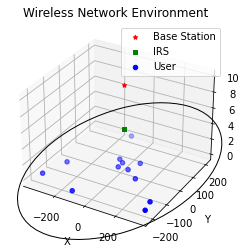

In [197]:
#============== System parameters
Nt = 1
nIRSrow = 2
nIRScol = nIRSrow
Ns = nIRSrow*nIRScol
Ns_max = 30
K = 12
# gamma = db2pow(20)
f = 2e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
# N0 = db2pow(-174-30)
B = 5
# sigma = np.sqrt(B*N0)
# epsilon = 1e-3
# Xi = 0.001
# relChange = 1e3
# iIter = 0
# objSeq = []

GRID_RADIUS = 500
BASE_STATION_POSITION = (0, 20, 10)
TRANSMIT_POWER_WATTS = 3.98 #in watts
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
PATH_LOSS_EXPONENT = 3.5 #path loss exponent (direct)
BETA = 2 #path loss exponent (indirect)
BANDWIDTH = 50*(10**6) #in Hz
m = 1
omega = 1.0

IRS_POSITION = (20, 0, 5)

# Generate user positions
user_positions = generate_user_positions_3D(K, GRID_RADIUS)
print('User positions:'"\n", user_positions)
print()
loc_U = user_positions
# print(loc_U)

# Generate antennas position
AP_position = generate_station_positions_3D(BASE_STATION_POSITION)
xt, yt, zt = AP_position[0]

# Generate IRS position
irs_position = generate_IRS_3D(IRS_POSITION)
xs, ys, zs = irs_position[0]

tx_ant_coords = generate_transmit_antenna_coordinates_3D(Nt, xt, yt, zt, halfLambda, quarterLambda)
loc_T = tx_ant_coords
print('Transmit antenna(e) coordinates:'"\n", loc_T) 
print()

irs_coords = generate_irs_coordinates_3D(xs, ys, zs, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S = irs_coords
print('IRS elements coordinates:'"\n", loc_S) 
print()

dTU, dSU, dTS = calculate_distances_3D(loc_U, loc_T, loc_S)

# Reshapiing the distance from antennas/BS to user
dTU = dTU.reshape(Nt,K)
# Compute row-wise averages
dSU = np.mean(dSU, axis=1, keepdims=True)
dSU = dSU.reshape(1,K)
# Compute the sum of elements in each row
dTS = np.mean(dTS, axis=1)
# Compute the average of row sums
dTS = np.mean(dTS)

print('Distances b/w the antennas and the users:'"\n", dTU)
print(np.shape(dTU))
print()
print('Distances b/w the IRS/IRS elements and the users:'"\n", dSU)
print(np.shape(dSU))
print()
print('Distances b/w the antennas and the IRS/IRS elements:'"\n", dTS)
print()

# Plot the 3D grid, base station, IRS, and user positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
ax.scatter(IRS_POSITION[0], IRS_POSITION[1], IRS_POSITION[2], color='green', marker='s', label='IRS')
ax.scatter(user_positions[:, 0], user_positions[:, 1], color='blue', marker='o', label='User')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Wireless Network Environment')
ax.legend()
ax.grid(True)

# Draw the circle in the x-y plane
circle = plt.Circle((xt, yt), (GRID_RADIUS), edgecolor='black', facecolor='none')
ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(circle, z=0, zdir='z')  # Add the circle to the x-y plane at z=zt
plt.show()

In [198]:
NUM_SIMULATIONS = 50
Ns_max = 45

h_dk_3d = []
h_rk_3d = []
h_rk_transpose_3d = []
G_3d = []

# Perform simulations
for i in range(NUM_SIMULATIONS):

    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk1 = []
    fading1 = []
    for user in range(K):
        fading1.append(generate_rayleigh_fading_channel(Nt, FADING_STD_MEAN, FADING_STD_DEV))
    h_dk1 = np.array(fading1)
    h_dk1 = h_dk1.reshape(Nt,K)
    h_dk_3d.append(h_dk1)
    
    # Generate the Nakagami Channel from each user to the IRS (h_rk)
    h_rk1 = []
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m, omega, Ns_max))
    h_rk1 = np.array(fading)
    h_rk1 = h_rk1.reshape(Ns_max,K)
    h_rk_3d.append(h_rk1)
    
    h_rk_conj = np.conj(h_rk1)
    h_rk_transpose1 = np.transpose(h_rk_conj)
    h_rk_transpose_3d.append(h_rk_transpose1)
    
    # Generate the Nakagami Channel from base_station to the IRS (G)
    G1 = []
    fading2 = []
    for element in range(Ns_max):
        fading2.append(generate_nakagami_samples(m, omega, Nt))
    G1 = np.array(fading2)
    G_3d.append(G1)

print("h_dk: \n", np.shape(h_dk_3d))
print()
print("h_rk: \n", np.shape(h_rk_3d))
print()
print("G: \n", np.shape(G_3d))

h_dk: 
 (50, 1, 12)

h_rk: 
 (50, 45, 12)

G: 
 (50, 45, 1)


In [199]:
# SISO IDEAL PHASE SHIFT MODEL WITH CONTINUOUS PHASE SHIFTS (MULTIPLE USERS)

qB = np.arange(2,4,1)
N_values = np.arange(5, Ns_max + 1, 1)
RATE_THRESHOLD = 30

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}

for B in qB:
    
    # Create a set of quantized theta values
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))
    
    average_outage_probabilities_1 = []
    sum_rates_1 = []

    for Ns in N_values:

        # Extract channel values for the current Ns value
        h_rk_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        
        # Initialize list to store individual outage probabilities
        outage_probabilities = []
        
        # Initialize sum-rates for this case
        sum_rate_N = 0  
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, K)
            h_rk = h_rk_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose = np.transpose(np.conj(h_rk))  # Shape: (K, Ns)
            G = G_ns_values[s]  # Shape: (Ns, 1)

            # Initialize an empty list to store theta_n values for each i
            theta_n_values_complex = []
            
            for i in range(K):
                theta_n_i = []
                for j in range(Ns):
                    theta_n = np.angle(h_rk[j][i]) - np.angle(G[j][0])
                    # theta_n = np.angle(h_dk[0][i]) - (np.angle(h_rk[j][i]) + np.angle(G[j][0]))
                
                    # Adjust theta_n to lie within the range (-π, π)
                    theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi
                    theta_n_i.append(theta_n)
                    
                theta_n_values_complex.append(1 * np.exp(1j * np.array(theta_n_i)))
            
            theta_n_values_complex = np.array(theta_n_values_complex)
            
            # Initialize an empty list to store diagonal matrices
            diagonal_matrices = []
            
            # Transform each row into a diagonal matrix
            for row in theta_n_values_complex:
                diagonal_matrix = np.diag(row[:Ns])
                diagonal_matrices.append(diagonal_matrix)
            
            # Convert diagonal_matrices to a NumPy array
            diagonal_matrices = np.array(diagonal_matrices)
            # print('Diagonal matrix: '"\n", (diagonal_matrices))
            # print(np.shape(diagonal_matrices))
            
            # Initialize an empty list to store the results for each column
            results_list = []
            
            # Loop over each row/user in the diagonal_matrices
            for row_index in range(diagonal_matrices.shape[0]):
                # Get the corresponding diagonal matrix for the current row/user
                single_row_diag = diagonal_matrices[row_index, :, :]
            
                # Extract the single column from f_m_transpose using indexing and transpose
                single_row = h_rk_transpose[row_index,:]
                
                # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
                result_inter = np.dot(single_row, single_row_diag)
            
                # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
                result = np.dot(result_inter, G)
                results_list.append(result)
            
            # Convert the list of results into a numpy array
            results_array = np.array(results_list)
            results_array = results_array.reshape(1,K)

            # Computing the intermediate link budget (complex result)
            link_inter = []
            
            for i in range(K):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/np.sqrt(dTU[0][i])**PATH_LOSS_EXPONENT + (results_array[0][i])/((dSU[0][i])**BETA * (dTS)**BETA)))
                link_inter.append(link_inter_value)  # Append the computed value to the list
            
            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)
            
            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30 
            link_budget = link_budget.reshape(1,K)
            
            #Calculate the noise value
            noise = -133 # in dBm
            
            SNR_matrix = []
            
            # Calculate SNR
            for i in range(K):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)
            
            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)
            
            # Calculate rate 
            rate_matrix = compute_rate((SNR_matrix))
            rate_matrix_new = rate_matrix.flatten()
            
            # Compute sum-rate for this iteration
            sum_rate_N += np.sum(rate_matrix_new)
            
            # Compute outage probability at each iteration
            outage_probability = compute_outage_probability(K, rate_matrix_new, RATE_THRESHOLD)
            outage_probabilities.append(outage_probability)
    
        # Compute average outage probability for the current N
        average_outage_probability = compute_average_outage_probability(outage_probabilities)
        average_outage_probabilities_1.append(average_outage_probability)
        
        # Append sum-rate for this N to the list
        sum_rates_1.append(sum_rate_N/1000)
        
    # Store the results in the dictionary with N as the key
    results_dict_1[B] = sum_rates_1
    
    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_outage_probabilities_1

print('done')
print(N_values)

done
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


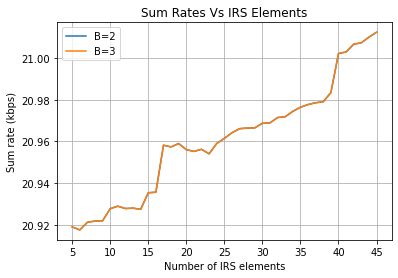

In [200]:
# # Plot the graph for each value of N
# for B, average_outage_probabilities_1 in results_dict_2.items():
#     plt.plot(N_values, average_outage_probabilities_1, label=f'B={B}')

# plt.ylabel('Average Outage Probability')
# plt.xlabel('Number of IRS elements')
# plt.title('Outage Probability Vs IRS Elements')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot the graph for each value of N
for B, sum_rates_1 in results_dict_1.items():
    plt.plot(N_values, sum_rates_1, label=f'B={B}')

plt.ylabel('Sum rate (kbps)')
plt.xlabel('Number of IRS elements')
plt.title('Sum Rates Vs IRS Elements')
plt.legend()
plt.grid(True)

# new_x_limits = (0, 35)
# new_y_limits = (22, 40)
# plt.xlim(new_x_limits)
# plt.ylim(new_y_limits)

plt.show()

In [201]:
# Initialize the vectors
qB = np.arange(2,4,1)
N_values = np.arange(5, Ns_max + 1, 1)
RATE_THRESHOLD = 30

# Initialize an empty dictionary to store the results
results_dict_3 = {}
results_dict_4 = {}

for B in qB:
    
    # Create a set of quantized theta values
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))
    
    average_outage_probabilities_2 = []
    sum_rates_2 = []

    for Ns in N_values:

        # Extract channel values for the current Ns value
        h_rk_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        
        # Initialize list to store individual outage probabilities
        outage_probabilities = []
        
        # Initialize sum-rates for this case
        sum_rate_N = 0  
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, K)
            h_rk = h_rk_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose = np.transpose(np.conj(h_rk))  # Shape: (K, Ns)
            G = G_ns_values[s]  # Shape: (Ns, 1)

            quantized_theta_n_values_complex = []
            
            for i in range(K):
                
                quantized_theta_n_i = []
                
                for j in range(Ns):
                    theta_n = np.angle(h_rk[j][i]) - np.angle(G[j][0])
                    # theta_n = np.angle(h_dk[0][i]) - (np.angle(h_rk[j][i]) + np.angle(G[j][0]))
                    
                    # Find the nearest quantized theta value
                    nearest_quantized_theta = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
                    
                    # Adjust theta_n to lie within the range (-π, π)
                    nearest_quantized_theta_new = (nearest_quantized_theta + np.pi) % (2 * np.pi) - np.pi
            
                    quantized_theta_n_i.append(nearest_quantized_theta_new)
                
                quantized_theta_n_values_complex.append(1 * np.exp(1j * np.array(quantized_theta_n_i)))
                        
            theta_n_values_complex = np.array(quantized_theta_n_values_complex)
            
            # Initialize an empty list to store diagonal matrices
            diagonal_matrices = []
            
            # Transform each row into a diagonal matrix
            for row in theta_n_values_complex:
                diagonal_matrix = np.diag(row[:Ns])
                diagonal_matrices.append(diagonal_matrix)
            
            # Convert diagonal_matrices to a NumPy array
            diagonal_matrices = np.array(diagonal_matrices)
            # print('Diagonal matrix: '"\n", (diagonal_matrices))
            # print(np.shape(diagonal_matrices))
            
            # Initialize an empty list to store the results for each column
            results_list = []
            
            # Loop over each row/user in the diagonal_matrices
            for row_index in range(diagonal_matrices.shape[0]):
                # Get the corresponding diagonal matrix for the current row/user
                single_row_diag = diagonal_matrices[row_index, :, :]
            
                # Extract the single column from f_m_transpose using indexing and transpose
                single_row = h_rk_transpose[row_index,:]
                
                # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
                result_inter = np.dot(single_row, single_row_diag)
            
                # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
                result = np.dot(result_inter, G)
                results_list.append(result)
            
            # Convert the list of results into a numpy array
            results_array = np.array(results_list)
            results_array = results_array.reshape(1,K)

            # Computing the intermediate link budget (complex result)
            link_inter = []
            
            for i in range(K):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/np.sqrt(dTU[0][i])**PATH_LOSS_EXPONENT + (results_array[0][i])/((dSU[0][i])**BETA * (dTS)**BETA)))
                link_inter.append(link_inter_value)  # Append the computed value to the list
            
            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)
            
            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30 
            link_budget = link_budget.reshape(1,K)
            
            #Calculate the noise value
            noise = -133 # in dBm
            
            SNR_matrix = []
            
            # Calculate SNR
            for i in range(K):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)
            
            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)
            
            # Calculate rate 
            rate_matrix = compute_rate((SNR_matrix))
            rate_matrix_new = rate_matrix.flatten()
            
            # Compute sum-rate for this iteration
            sum_rate_N += np.sum(rate_matrix_new)
            
            # Compute outage probability at each iteration
            outage_probability = compute_outage_probability(K, rate_matrix_new, RATE_THRESHOLD)
            outage_probabilities.append(outage_probability)
    
        # Compute average outage probability for the current N
        average_outage_probability = compute_average_outage_probability(outage_probabilities)
        average_outage_probabilities_2.append(average_outage_probability)
        
        # Append sum-rate for this N to the list
        sum_rates_2.append(sum_rate_N/1000)
        
    # Store the results in the dictionary with N as the key
    results_dict_3[B] = sum_rates_2
    
    # Store the results in the dictionary with N as the key
    results_dict_4[B] = average_outage_probabilities_2

print('done')

done


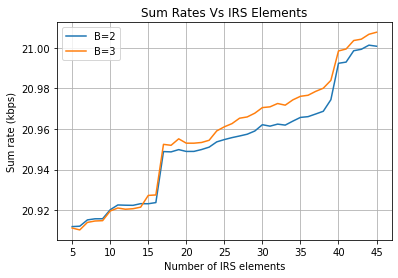

In [202]:
# # Plot the graph for each value of N
# for B, average_outage_probabilities_2 in results_dict_4.items():
#     plt.plot(N_values, average_outage_probabilities_2, label=f'B={B}')

# plt.ylabel('Average Outage Probability')
# plt.xlabel('Number of IRS elements')
# plt.title('Outage Probability Vs IRS Elements')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot the graph for each value of N
for B, sum_rates_2 in results_dict_3.items():
    plt.plot(N_values, sum_rates_2, label=f'B={B}')

plt.ylabel('Sum rate (kbps)')
plt.xlabel('Number of IRS elements')
plt.title('Sum Rates Vs IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

In [203]:
# Initialize the vectors
qB = np.arange(2,4,1)
N_values = np.arange(5, Ns_max + 1, 1)
RATE_THRESHOLD = 30

# Practical phase shift model parameters
beta_min = 0.2
k = 1.6
phi = 0.43 * np.pi

# Initialize an empty dictionary to store the results
results_dict_5 = {}
results_dict_6 = {}

for B in qB:
    
    # Create a set of quantized theta values
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))
    
    average_outage_probabilities_3 = []
    sum_rates_3 = []

    for Ns in N_values:

        # Extract channel values for the current Ns value
        h_rk_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        
        # Initialize list to store individual outage probabilities
        outage_probabilities = []
        
        # Initialize sum-rates for this case
        sum_rate_N = 0  
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, K)
            h_rk = h_rk_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose = np.transpose(np.conj(h_rk))  # Shape: (K, Ns)
            G = G_ns_values[s]  # Shape: (Ns, 1)

            theta_n_values_complex = []
            theta_n_vals = []
            
            for i in range(K):
                beta_n = []
                theta_n_i = []
                for j in range(Ns):
                    theta_n = np.angle(h_rk[j][i]) - np.angle(G[j][0])
                    # theta_n = np.angle(h_dk[0][i]) - (np.angle(h_rk[j][i]) + np.angle(G[j][0]))
                    
                    # Adjust theta_n to lie within the range (-π, π)
                    theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi
                    theta_n_i.append(theta_n)
                    
                    beta_theta_n = ((1 - beta_min) * ((np.sin(theta_n - phi) + 1) / 2) ** k + beta_min)
                    beta_theta_n = np.clip(beta_theta_n, 0, 1)
                    beta_n.append(beta_theta_n)
                
                theta_n_vals.append(theta_n_i)
                theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(theta_n_i)))
                
            theta_n_values_complex = np.array(theta_n_values_complex)
            
            # Initialize an empty list to store diagonal matrices
            diagonal_matrices = []
            
            # Transform each row into a diagonal matrix
            for row in theta_n_values_complex:
                diagonal_matrix = np.diag(row[:Ns])
                diagonal_matrices.append(diagonal_matrix)
            
            # Convert diagonal_matrices to a NumPy array
            diagonal_matrices = np.array(diagonal_matrices)
            # print('Diagonal matrix: '"\n", (diagonal_matrices))
            # print(np.shape(diagonal_matrices))
            
            # Initialize an empty list to store the results for each column
            results_list = []
            
            # Loop over each row/user in the diagonal_matrices
            for row_index in range(diagonal_matrices.shape[0]):
                # Get the corresponding diagonal matrix for the current row/user
                single_row_diag = diagonal_matrices[row_index, :, :]
            
                # Extract the single column from f_m_transpose using indexing and transpose
                single_row = h_rk_transpose[row_index,:]
                
                # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
                result_inter = np.dot(single_row, single_row_diag)
            
                # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
                result = np.dot(result_inter, G)
                results_list.append(result)
            
            # Convert the list of results into a numpy array
            results_array = np.array(results_list)
            results_array = results_array.reshape(1,K)

            # Computing the intermediate link budget (complex result)
            link_inter = []
            
            for i in range(K):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/np.sqrt(dTU[0][i])**PATH_LOSS_EXPONENT + (results_array[0][i])/((dSU[0][i])**BETA * (dTS)**BETA)))
                link_inter.append(link_inter_value)  # Append the computed value to the list
            
            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)
            
            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30 
            link_budget = link_budget.reshape(1,K)
            
            #Calculate the noise value
            noise = -133 # in dBm
            
            SNR_matrix = []
            
            # Calculate SNR
            for i in range(K):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)
            
            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)
            
            # Calculate rate 
            rate_matrix = compute_rate((SNR_matrix))
            rate_matrix_new = rate_matrix.flatten()
            
            # Compute sum-rate for this iteration
            sum_rate_N += np.sum(rate_matrix_new)
            
            # Compute outage probability at each iteration
            outage_probability = compute_outage_probability(K, rate_matrix_new, RATE_THRESHOLD)
            outage_probabilities.append(outage_probability)
    
        # Compute average outage probability for the current N
        average_outage_probability = compute_average_outage_probability(outage_probabilities)
        average_outage_probabilities_3.append(average_outage_probability)
        
        # Append sum-rate for this N to the list
        sum_rates_3.append(sum_rate_N/1000)
        
    # Store the results in the dictionary with N as the key
    results_dict_5[B] = sum_rates_3
    
    # Store the results in the dictionary with N as the key
    results_dict_6[B] = average_outage_probabilities_3

print('done')

done


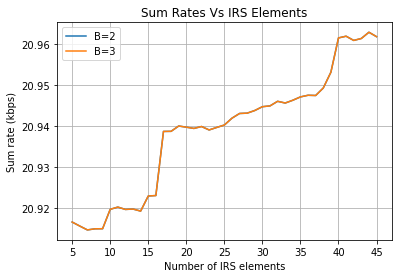

In [204]:
# # Plot the graph for each value of N
# for B, average_outage_probabilities_3 in results_dict_6.items():
#     plt.plot(N_values, average_outage_probabilities_3, label=f'B={B}')

# plt.ylabel('Average Outage Probability')
# plt.xlabel('Number of IRS elements')
# plt.title('Outage Probability Vs IRS Elements')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot the graph for each value of N
for B, sum_rates_3 in results_dict_5.items():
    plt.plot(N_values, sum_rates_3, label=f'B={B}')

plt.ylabel('Sum rate (kbps)')
plt.xlabel('Number of IRS elements')
plt.title('Sum Rates Vs IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Initialize the vectors
qB = np.arange(2,4,1)
N_values = np.arange(5, Ns_max + 1, 1)
RATE_THRESHOLD = 30

# Initialize an empty dictionary to store the results
results_dict_7 = {}
results_dict_8 = {}

for B in qB:
    
    # Create a set of quantized theta values
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))
    
    average_outage_probabilities_4 = []
    sum_rates_4 = []

    for Ns in N_values:

        # Extract channel values for the current Ns value
        h_rk_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        
        # Initialize list to store individual outage probabilities
        outage_probabilities = []
        
        # Initialize sum-rates for this case
        sum_rate_N = 0  
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, K)
            h_rk = h_rk_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose = np.transpose(np.conj(h_rk))  # Shape: (K, Ns)
            G = G_ns_values[s]  # Shape: (Ns, 1)

            # Initialize an empty list to store quantized theta_n values for each i
            quantized_theta_n_values_complex = []
            
            for i in range(K):
                
                beta_n = []
                quantized_theta_n_i = []
                
                for j in range(Ns):
                    theta_n = np.angle(h_rk[j][i]) - np.angle(G[j][0])
                    # theta_n = np.angle(h_dk[0][i]) - (np.angle(h_rk[j][i]) + np.angle(G[j][0]))
                    
                    # Find the nearest quantized theta value
                    nearest_quantized_theta = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
                    
                    # Adjust theta_n to lie within the range (-π, π)
                    nearest_quantized_theta_new = (nearest_quantized_theta + np.pi) % (2 * np.pi) - np.pi
            
                    quantized_theta_n_i.append(nearest_quantized_theta_new)
                    
                    beta_theta_n = ((1 - beta_min) * ((np.sin(nearest_quantized_theta_new - phi) + 1) / 2) ** k + beta_min)
                    beta_theta_n = np.clip(beta_theta_n, 0, 1)
                    beta_n.append(beta_theta_n)
                
                quantized_theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(quantized_theta_n_i)))
                
            theta_n_values_complex = np.array(quantized_theta_n_values_complex)
            
            # Initialize an empty list to store diagonal matrices
            diagonal_matrices = []
            
            # Transform each row into a diagonal matrix
            for row in theta_n_values_complex:
                diagonal_matrix = np.diag(row[:Ns])
                diagonal_matrices.append(diagonal_matrix)
            
            # Convert diagonal_matrices to a NumPy array
            diagonal_matrices = np.array(diagonal_matrices)
            # print('Diagonal matrix: '"\n", (diagonal_matrices))
            # print(np.shape(diagonal_matrices))
            
            # Initialize an empty list to store the results for each column
            results_list = []
            
            # Loop over each row/user in the diagonal_matrices
            for row_index in range(diagonal_matrices.shape[0]):
                # Get the corresponding diagonal matrix for the current row/user
                single_row_diag = diagonal_matrices[row_index, :, :]
            
                # Extract the single column from f_m_transpose using indexing and transpose
                single_row = h_rk_transpose[row_index,:]
                
                # Perform the dot product between f_m_transpose (5, 10) and the current diagonal matrix (10, 10)
                result_inter = np.dot(single_row, single_row_diag)
            
                # Perform the final matrix multiplication of the result_inter (5, 10) and g (10, 1)
                result = np.dot(result_inter, G)
                results_list.append(result)
            
            # Convert the list of results into a numpy array
            results_array = np.array(results_list)
            results_array = results_array.reshape(1,K)

            # Computing the intermediate link budget (complex result)
            link_inter = []
            
            for i in range(K):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/np.sqrt(dTU[0][i])**PATH_LOSS_EXPONENT + (results_array[0][i])/((dSU[0][i])**BETA * (dTS)**BETA)))
                link_inter.append(link_inter_value)  # Append the computed value to the list
            
            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)
            
            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30 
            link_budget = link_budget.reshape(1,K)
            
            #Calculate the noise value
            noise = -133 # in dBm
            
            SNR_matrix = []
            
            # Calculate SNR
            for i in range(K):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)
            
            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)
            
            # Calculate rate 
            rate_matrix = compute_rate((SNR_matrix))
            rate_matrix_new = rate_matrix.flatten()
            
            # Compute sum-rate for this iteration
            sum_rate_N += np.sum(rate_matrix_new)
            
            # Compute outage probability at each iteration
            outage_probability = compute_outage_probability(K, rate_matrix_new, RATE_THRESHOLD)
            outage_probabilities.append(outage_probability)
    
        # Compute average outage probability for the current N
        average_outage_probability = compute_average_outage_probability(outage_probabilities)
        average_outage_probabilities_4.append(average_outage_probability)
        
        # Append sum-rate for this N to the list
        sum_rates_4.append(sum_rate_N/1000)
        
    # Store the results in the dictionary with N as the key
    results_dict_7[B] = sum_rates_4
    
    # Store the results in the dictionary with N as the key
    results_dict_8[B] = average_outage_probabilities_4

print('done')

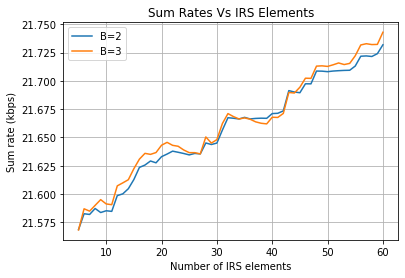

In [39]:
# # Plot the graph for each value of N
# for B, average_outage_probabilities_4 in results_dict_8.items():
#     plt.plot(N_values, average_outage_probabilities_4, label=f'B={B}')

# plt.ylabel('Average Outage Probability')
# plt.xlabel('Number of IRS elements')
# plt.title('Outage Probability Vs IRS Elements')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot the graph for each value of N
for B, sum_rates_4 in results_dict_7.items():
    plt.plot(N_values, sum_rates_4, label=f'B={B}')

plt.ylabel('Sum rate (kbps)')
plt.xlabel('Number of IRS elements')
plt.title('Sum Rates Vs IRS Elements')
plt.legend()
plt.grid(True)
plt.show()